Contour plot of ln(evidence) for loss against number of layers\
for limited and not limited thickness

for below has no limit on max thickness\
above has a limits of punishishing the fitting of total thickness > 350 (for the varying slabs)

In [1]:
import os.path
import numpy as np
import matplotlib.pyplot as plt
import scipy
import refnx
from refnx.dataset import ReflectDataset, Data1D
from refnx.analysis import Transform, CurveFitter, Objective, Model, Parameter
from refnx.reflect import SLD, Slab, ReflectModel
from sepObjective import getObjective as gO
from dynesty import DynamicNestedSampler
from dynesty import plotting as dyplot
from CFitter2 import CFitter
import make_sim_data as msd
print('refnx: %s\nscipy: %s\nnumpy: %s' % (refnx.version.version,
                   scipy.version.version, np.version.version))
%matplotlib inline
#%matplotlib noteboo

refnx: 0.1.9
scipy: 1.3.0
numpy: 1.16.4
refnx: 0.1.9
scipy: 1.3.0
numpy: 1.16.4


In [2]:
maxLength = 350
def logp_extra(model, data=None):
    returns = 0
    if sum(model.structure.slabs()[1:-1,0])>maxLength:
        returns = -np.inf
    return returns

In [3]:

# simple structure
thicks_true = [10,120,100,130,10]
bs_true = [0,5,4.5,5,10]
roughs_true = [0,0,0,0,0]
# bs = [5,4.5,5]
# thicks = [120,100,130]
# roughs = [0,0,0]
bs = bs_true
thicks = thicks_true
roughs = roughs_true
loss = 1.
no_layers = len(bs)
no_layers = len(bs_true)
# no_layers = 3
layers = []
names = []
#names = ['layer1','layer2']
for i in range(no_layers):
    names.append('layer'+str(i))
for i in range(no_layers):
        sld = SLD(bs[i],name=names[i])
        layers.append(sld(thicks[i],roughs[i]))
structure = layers[0]
for layer in layers[1:]:
    structure|=layer
print("done")

done


done


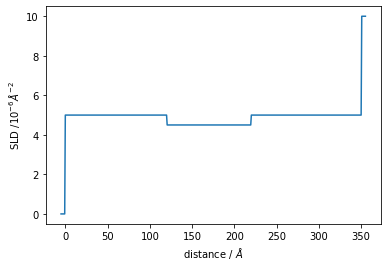

In [4]:
%matplotlib inline
figI = 0
# plt.figure(figI)
# figI+=1
plt.plot(*structure.sld_profile())
plt.ylabel('SLD /$10^{-6} \AA^{-2}$')
plt.xlabel('distance / $\AA$');
print("done")

In [5]:
resolution = 5.
model = ReflectModel(structure, bkg=3e-6, dq=resolution)

In [6]:
q = np.linspace(0.005, 0.3, 70)
# losses = np.linspace(0.v5,1.,4)#[0.5,0.,0.75,0.9,1]
resolutions = np.array([9.])
# datas = []
objectives1 = []
# results1 = []
lnPosts1 = []
structures1 = []
lnEvidence1 = []

objectives2 = []
# results2 = []
lnPosts2 = []
structures2 = []
lnEvidence2 = []

for resolution in resolutions:
    R = model(q, x_err=resolution)
    sim_dR = msd.main(sim_q=q,sim_R=R)*10 # was sim_R=R*loss, double counting loss
    data = Data1D(data=(q,R,sim_dR))
#     datas.append(data)
    for i in range(4,5):
#         print("\nresolution:",resolution,"n layers:", i)
#         objective = gO(data, i, logpExtra=logp_extra)
#         fitter = CFitter(objective)
#         DNSampler = DynamicNestedSampler(fitter.logl, fitter.priorTransform, fitter.nDim())
#         DNSampler.run_nested(dlogz_init=0.05)#0.01)
#         result = DNSampler.results
#         objectives1.append(objective)
#         lnEvidence = result["logz"][-1]
#         print("thickness limited lnEvidence:",lnEvidence)
#         lnEvidence1.append(lnEvidence)

        objective = gO(data, i)
        fitter = CFitter(objective)
        DNSampler = DynamicNestedSampler(fitter.logl, fitter.priorTransform, fitter.nDim())
        DNSampler.run_nested(dlogz_init=0.05)#0.01)
        result = DNSampler.results
        objectives2.append(objective)
        lnEvidence = result["logz"][-1]
        print("lnEvidence:",lnEvidence)
        lnEvidence2.append(lnEvidence)



csv
cvs-collecting
out  [3.47819830e+02 8.77904741e+01 3.20810699e+03 9.49732939e-37
 1.65307010e-05] 
var:  [[1.76447440e+01 1.39762075e+02 1.90993913e+00 2.55098590e+04
  6.99628049e-05]
 [1.39762075e+02 1.10704093e+03 1.51284720e+01 2.01610925e+05
  5.54070662e-04]
 [1.90993913e+00 1.51284720e+01 2.06742813e-01 2.73481708e+03
  7.56735044e-06]
 [2.55098590e+04 2.01610925e+05 2.73481708e+03 2.55670288e+08
  1.48331018e-01]
 [6.99628049e-05 5.54070662e-04 7.56735044e-06 1.48331018e-01
  2.92147690e-10]]


34092it [35:47:50,  3.78s/it, batch: 7 | bound: 66037 | nc: 8 | ncall: 50096842 | eff(%):  0.068 | loglstar: -79.769 < -69.809 < -70.077 | logz: -96.455 +/-  0.288 | stop:  0.885]              


lnEvidence: -96.4403717625225


In [7]:
f=open("dLVsNLLnEvidence.txt","w+")
f.write("limited max thickness ln(evidence):\n")
for lnEvidence in lnEvidence1:
    f.write(str(lnEvidence))
f.write("\nnot limited max thickness ln(evidence):\n")
for lnEvidence in lnEvidence2:
    f.write(str(lnEvidence))
f.close()

In [8]:
def toArray(line,n,m=-1):
    array=line.reshape((n,m))
    return array

def meshGraph(line, xs, ys, xlabel="", ylabel="", title="",printType="", figI=0):
    #resolutions = [1.,3.,7.,9.]
    #dRScaleBys = [5,10,15,20]
    ha_s = ["left", "center", "center", "right"]

    print(printType,line)#"not thickness limited ln(post):",line)
    n, m = len(xs), len(ys)
    zs = toArray(line,m,n)
#     zs= np.array(lnPosts1).reshape(len(xs), len(ys))
    plt.figure(figI)
    figI+=1
    plt.contour(xs,ys,zs,alpha=0.5);
    plt.contourf(xs,ys,zs,alpha=0.3);
    plt.colorbar();
    for i in range(len(xs)):
        for j in range(len(ys)):
            plt.scatter(xs[i],ys[j],c="red",marker="x");
            ha = ha_s[i]
            plt.annotate("%.3f"%zs[j][i],(xs[i],ys[j]),
                        horizontalalignment=ha, fontsize="small", verticalalignment='bottom')
    # for x in dRScaleBys:
    #     for y in resolutions:
    #         plt.scatter(x,y,c="red",marker="x");
    plt.ylabel(ylabel);#"dq");
    plt.xlabel(xlabel);#"dR scaled by");
    plt.title(title);#"thickness limited contour plot of ln(evidence) for dq vs dR scaled by");
    plt.tight_layout();
    plt.show();
    return figI

# Corrected

thickness limited contour plot of ln(evidence) for layers vs dq [-2138.4038612   -234.86000113  -173.18861293  -174.26751842
 -1955.49828719   -59.86366147   -10.91114164   -11.33571912
 -1818.47329218    68.62163329    90.74089744    89.2876641
 -1855.99090275    13.04800373    34.57502861    41.92321263
 -1994.8733284   -154.82456441  -114.49061474   -96.7036977 ]


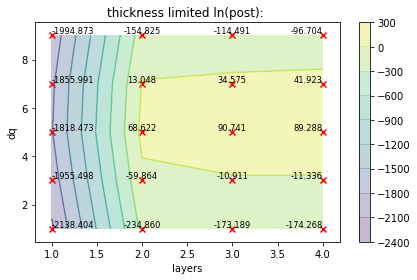

1

In [12]:
# line = np.array([-22028.153704017514, -21411.499726942773, -20799.212681368404, -20710.241902463604, -8527.26418299856, -7092.652657222519, -6987.757049967671, -6968.409004941244, -2826.8961462523416, -1294.463309916167, -1287.9091175952526, -1289.8879661963538, -1818.411075758853, 72.97116284294752, 91.13733292229811, 89.57239055379468])
nLayers = [i for i in range(1,5)]
resolutions=[1.,3., 5.,7.,9.]
ylabel="dq"
xlabel="layers"
title="thickness limited contour plot of ln(evidence) for layers vs dq"
lnEvidence1 =np.array([ -2138.4038611988913,-234.86000113353825, -173.18861293092868, -174.26751841938466,
                      -1955.4982871915593, -59.86366147278026, -10.91114163548692, -11.335719123126482,
                      -1818.4732921763934, 68.62163328826037, 90.74089744021738, 89.28766410048205, 
                      -1855.9909027469307, 13.048003728514862, 34.57502861100475, 41.92321263070505,
                      -1994.87332839974, -154.8245644057317, -114.49061473995881, -96.70369770372983])
meshGraph(lnEvidence1, nLayers, resolutions, xlabel, ylabel,"thickness limited ln(post): ", title)

# line=np.array([-22028.184688274174, -21411.130122513667, -20803.32327289713, -20710.614379519593, -8527.527221022197, -7092.5936011602935, -6987.740416257086, -6968.700627526253, -2826.7346983527063, -1294.5262220939194, -1287.7645545727062, -1289.860225072015, -1818.2508356726373, 72.29432028604006, 91.11035384560891, 89.53605708217408])
# title="not thickness limited contour plot of ln(evidence) for layers vs dq"
# meshGraph(lnEvidence2, nLayers, resolutions, xlabel, ylabel,"not thickness limited ln(post): ", title)


# previous version

In [ ]:
%%time

ha_s = ["left", "center", "center", "right"]

print(lnEvidence1)
lenLosses = len(losses)
nLayers = [i for i in range(1,5)]

z = np.array(lnEvidence1).reshape((-1,lenLosses))

# plt.figure(figI);
# figI+=1
plt.contour(losses,nLayers,z,alpha=0.5);
plt.contourf(losses,nLayers,z,alpha=0.3);
plt.colorbar();
for i in range(len(losses)):#x in losses:
    for j in range(len(nLayers)): #y in nLayers:
        plt.scatter(losses[i],nLayers[j],c="red",marker="x");
        ha = ha_s[i]
        plt.annotate("%.2f"%z[j][i],(losses[i],nLayers[j]),
                    horizontalalignment=ha, fontsize="small", verticalalignment='bottom')
plt.ylabel("layers");
plt.xlabel("1-loss");
plt.title("thickness limited contour plot of ln(evidence) for layers vs loss");
plt.tight_layout();
plt.show();
#--------

print(lnEvidence2)
lenLosses = len(losses)
nLayers = [i for i in range(1,5)]

z = np.array(lnEvidence2).reshape((-1,lenLosses))

# plt.figure(figI);
# figI+=1
plt.contour(losses,nLayers,z,alpha=0.5);
plt.contourf(losses,nLayers,z,alpha=0.3);
plt.colorbar();
# for x in losses:
#     for y in nLayers:
#         plt.scatter(x,y,c="red",marker="x");

for i in range(len(losses)):#x in losses:
    for j in range(len(nLayers)): #y in nLayers:
        plt.scatter(losses[i],nLayers[j],c="red",marker="x");
        ha = ha_s[i]
        plt.annotate("%.2f"%z[j][i],(losses[i],nLayers[j]),
                    horizontalalignment=ha, fontsize="small", verticalalignment='bottom')
plt.ylabel("layers");
plt.xlabel("1-loss");
plt.title("not thickness limited contour plot of ln(evidence) for layers vs 1-loss");
plt.tight_layout();
plt.show();

In [ ]:
# for objective1,objective2 in zip(objectives1,objectives2):
#     plt.figure(figI)
#     figI+=1

# #     plt.subplot(2,2,1).set_title("data plotted for limited max thickness")
#     fig, ax = objective1.plot()
#     plt.figure(figI)
#     figI+=1
# #     plt.subplot(2,2,2).set_title("structure plotted for limited max thickness")
#     plt.plot(*objective1.model.structure.sld_profile())
#     plt.ylabel('SLD /$10^{-6} \AA^{-2}$')
#     plt.xlabel('distance / $\AA$');
#     plt.figure(figI)
#     figI+=1

# #     plt.subplot(2,2,3).set_title("data plotted for limited max thickness")
#     fig, ax = objective2.plot()
#     plt.figure(figI)
#     figI+=1
# #     plt.subplot(2,2,4).set_title("structure plotted for limited max thickness")
#     plt.plot(*objective2.model.structure.sld_profile())
#     plt.ylabel('SLD /$10^{-6} \AA^{-2}$')
#     plt.xlabel('distance / $\AA$');

# #     plt.tight_layout();
